# Milestone 2: Feature Engineering & Baseline Model Development

This notebook implements the second milestone of the Smart Energy Consumption Analysis project. It includes:
1. **Data Loading & Cleaning:** Reproducing steps from Milestone 1 to ensure a standalone pipeline.
2. **Feature Engineering:** Creating time-based, lag, rolling, and device-level features.
3. **Baseline Modeling:** Training and evaluating a Linear Regression model.
4. **Evaluation:** Visualizing results and calculating MAE, RMSE, and R2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Set plot style
plt.style.use('seaborn-v0_8')

## 1. Data Loading and Preprocessing (Reproducing Milestone 1)

To ensure this notebook is self-contained, we reload and clean the raw data.

In [2]:
file_path = 'C:\\Sindhu\\infosys springboard project\\household_power_consumption.txt'

try:
    # Load dataset with specified separator and NaNs
    df = pd.read_csv(file_path, 
                    sep=';', 
                    low_memory=False,
                    na_values=['?', ''])
    
    print(f"Dataset loaded successfully!")
    print(f"Total records: {len(df):,}")
    
    # Create Datetime index
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df = df.set_index('Datetime')
    df = df.drop(columns=['Date', 'Time'])
    
    # Handle missing values (Interpolation)
    df = df.interpolate(method='time')
    
    # Resample to hourly frequency
    df_hourly = df.resample('h').mean()
    
    print("Preprocessing complete.")
    print(f"New shape after resampling: {df_hourly.shape}")
    
except FileNotFoundError:
    print("ERROR: Dataset file not found at specified path.")

Dataset loaded successfully!
Total records: 2,075,259
Preprocessing complete.
New shape after resampling: (34589, 7)


#### 2. Feature Engineering

We will create several types of features to help the model learn patterns:
- **Time-based:** Hour, Day, Month, Weekend flag.
- **Lag features:** Previous hour and previous day consumption.
- **Rolling stats:** Moving averages and standard deviation.
- **Device-level:** Aggregations and peak usage indicators.

In [3]:
# 2.1 Time-based Features
df_hourly['Hour'] = df_hourly.index.hour
df_hourly['DayOfWeek'] = df_hourly.index.dayofweek
df_hourly['Month'] = df_hourly.index.month
df_hourly['IsWeekend'] = df_hourly['DayOfWeek'].isin([5, 6]).astype(int)

# 2.2 Lag Features
# Lag 1: Consumption 1 hour ago
df_hourly['Global_active_power_lag1'] = df_hourly['Global_active_power'].shift(1)
# Lag 24: Consumption 24 hours ago (same hour yesterday)
df_hourly['Global_active_power_lag24'] = df_hourly['Global_active_power'].shift(24)

# 2.3 Rolling Statistics
# 3-hour moving average
df_hourly['Rolling_Mean_3h'] = df_hourly['Global_active_power'].rolling(window=3).mean()
# 24-hour moving average
df_hourly['Rolling_Mean_24h'] = df_hourly['Global_active_power'].rolling(window=24).mean()
# 24-hour rolling standard deviation
df_hourly['Rolling_Std_24h'] = df_hourly['Global_active_power'].rolling(window=24).std()

# 2.4 Device-Level Aggregations
# Represent 'Average consumption per device' via rolling averages of sub-metering
df_hourly['Sub_metering_1_DailyAvg'] = df_hourly['Sub_metering_1'].rolling(window=24).mean()
df_hourly['Sub_metering_2_DailyAvg'] = df_hourly['Sub_metering_2'].rolling(window=24).mean()
df_hourly['Sub_metering_3_DailyAvg'] = df_hourly['Sub_metering_3'].rolling(window=24).mean()

# Peak Usage Indicator (e.g., 7-9 AM and 6-10 PM)
def is_peak(hour):
    if (7 <= hour <= 9) or (18 <= hour <= 22):
        return 1
    return 0

df_hourly['IsPeak'] = df_hourly['Hour'].apply(is_peak)

print("Feature Engineering complete.")
print(df_hourly.columns)

Feature Engineering complete.
Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
       'Global_active_power_lag1', 'Global_active_power_lag24',
       'Rolling_Mean_3h', 'Rolling_Mean_24h', 'Rolling_Std_24h',
       'Sub_metering_1_DailyAvg', 'Sub_metering_2_DailyAvg',
       'Sub_metering_3_DailyAvg', 'IsPeak'],
      dtype='object')


## 3. Data Preparation for Modeling

Cleaning NaNs created by lag features and splitting into Train/Test sets.

In [4]:
# Drop rows with missing values (due to lags/rolling)
df_clean = df_hourly.dropna()

# Define Target and Features
target = 'Global_active_power'
# Use all columns except target as features
features = [col for col in df_clean.columns if col != target]

X = df_clean[features]
y = df_clean[target]

# Split into Train and Test (Time-series split, no shuffling)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

Training Set: (27652, 19)
Test Set: (6913, 19)


## 4. Baseline Model Construction

We use a simple Linear Regression model to establish a baseline performance.

In [5]:
# Initialize and train
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

print("Model trained successfully.")

Model trained successfully.


## 5. Model Evaluation

Evaluating using MAE, RMSE, and R2 score.

In [6]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0129
Root Mean Squared Error (RMSE): 0.0201
R2 Score: 0.9992


## 6. Visualization and Saving

Visualizing the Actual vs Predicted values for a subset of the test data.

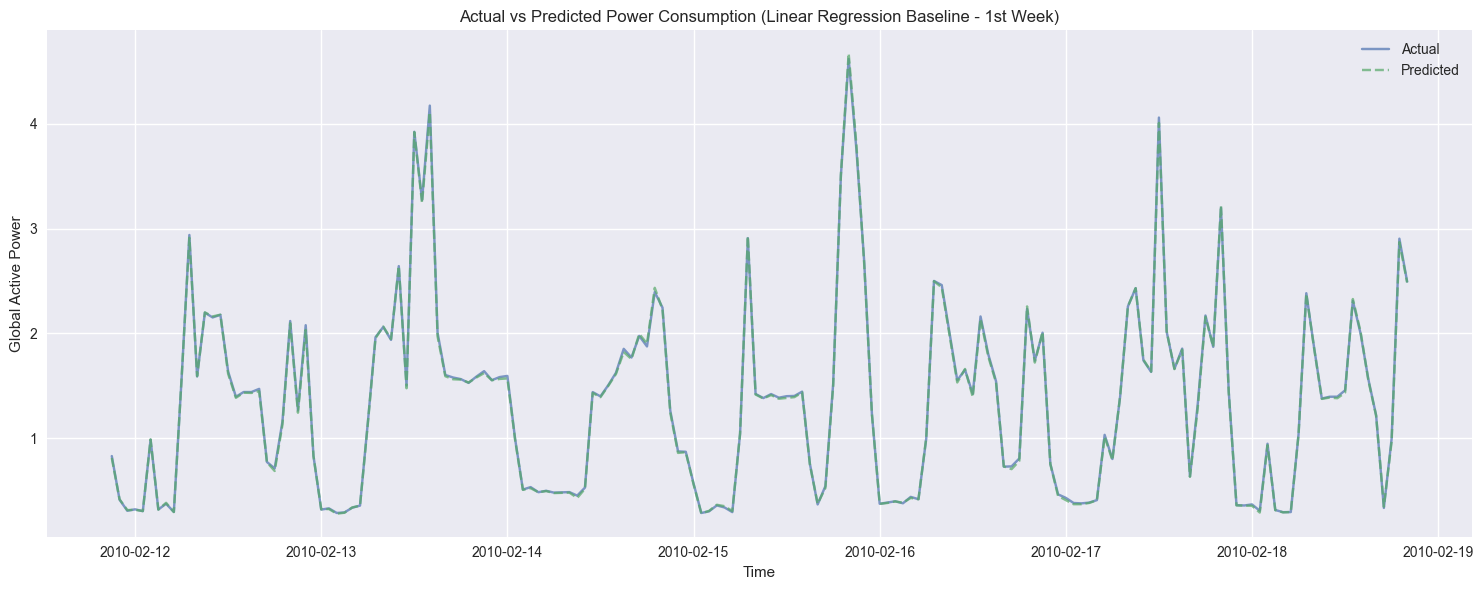

<Figure size 800x550 with 0 Axes>

In [9]:
plt.figure(figsize=(15, 6))
# Plotting the first week of test data for clarity
hours_to_plot = 7 * 24

plt.plot(y_test.index[:hours_to_plot], y_test.iloc[:hours_to_plot], label='Actual', alpha=0.7)
plt.plot(y_test.index[:hours_to_plot], y_pred[:hours_to_plot], label='Predicted', alpha=0.7, linestyle='--')

plt.title('Actual vs Predicted Power Consumption (Linear Regression Baseline - 1st Week)')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('milestone2_baseline_results.png')

In [ ]:
# Save model and processed data
joblib.dump(model, 'baseline_linear_regression.pkl')
df_clean.to_csv('feature_engineered_data.csv')

print("Artifacts saved: 'baseline_linear_regression.pkl', 'feature_engineered_data.csv', 'milestone2_baseline_results.png'")

Artifacts saved: 'baseline_linear_regression.pkl', 'feature_engineered_data.csv', 'milestone2_baseline_results.png'
